# Caterpillar Tube Pricing

### Project 1 - Visualization and Data Preprocessing¶
Team Members:
1. Oscar Padilla
2. Najeeb Zaidi
3. Harry Bhasin

Model quoted prices for industrial tube assemblies

Source: Kaggle

https://www.kaggle.com/c/caterpillar-tube-pricing

21 files provided
3 files merged using SQL: train_set, specs, tube

Data Set Description
Caterpillar builds large earth moving machines for constructions and mining. Each machine comprises of several smaller componenents including tubes to help keep the moving parts moving. There are two tube assemblies that come in a number of dimentions with several base materials, number of bends, bend radius, bolt patterns, and end types. Our team decided to use tubing data set for this project, predicting the price a supplier will quote for a given assembly.


The goal from the following section is to interrogate various contributing factors in the assembly, the structure/bend/dimension factor of each tube, sub components, vendor, and the pricing per quantity. The result of this section will produce a single data set with relevant attributes both continuous and categorical.
In an effort to create a single data set from several different data files SQL was used to do a join before further formatting the data. The outcome is a single data set consisting of approximately 30K records with 32 columns. This columns with different variable names are described below.


tube_assembly_id: This variable is to identify the tube.

supplier: This variable holds the vendor's identification number.

quote_date: This variable has the date of the quote. The formatting was done to this variable.

annual_usage: This variable is tied to the date of the quote and stores the usage.

min_order_quantity: This variable is tied to the price as the quantity is used for pricing.

bracket_pricing: This variable holds the pricing with or without bracket.

quantity: The cost is given assuming purchase of quantity of tubes.

cost tube_assembly: This variable holds the price based on the quantity ordered.

spec1 - spec10: These variables hold the unique specifications with respective codes for the tube assembly.

material_id: This variable holds the code for the material.

diameter: This variable holds the diameter of the ordered tube.

wall: This variable holds the thickness of the tube wall.

length: This variable holds the length of the tube.

num_bends: The variable holds the number of bends in a given tube assembly.

bend_radius: This varibale holds the radius of the respected bend.

end_a_1x, end_a_2x, end_x_1x, end_x_2x, end_a, end_x: These variables hold the code for the shape of different ends of the tube.

num_boss: This variable holds the quantity of boss.

num_bracket: This variable holds the number of brackets in a given tube.

Tube Assemblies are made of multiple parts. The main piece is the tube which has a specific diameter, wall thickness, length, number of bends and bend radius. Either end of the tube (End A or End X) typically has some form of end connection allowing the tube assembly to attach to other features. Special tooling is typically required for short end straight lengths (end_a_1x, end_a_2x refer to if the end length is less than 1 times or 2 times the tube diameter, respectively). Other components can be permanently attached to a tube such as bosses, brackets or other custom features.

Prices can be quoted in 2 ways: bracket and non-bracket pricing. Bracket pricing has multiple levels of purchase based on quantity (in other words, the cost is given assuming a purchase of quantity tubes). Non-bracket pricing has a minimum order amount (min_order) for which the price would apply. Each quote is issued with an annual_usage, an estimate of how many tube assemblies will be purchased in a given year.


In [394]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# import consolidated file

df = pd.read_csv('/Users/GS7271/Documents/MSDS7331/Project/train_set.csv')

# eliminate redundant primary keys leftover from SQL merge

del df['tube_assembly']
del df['tube_assembly.1']
del df['spec10']

# convert variables to the right type

df['quote_date'] = pd.to_datetime(df['quote_date'],format="%Y-%m-%d")

df = df.replace("Y", 1)
df = df.replace("N", 0)
df = df.replace("Yes", 1)
df = df.replace("No", 0)

df['bracket_pricing']=df['bracket_pricing'].astype('bool')
df['end_a_1x']=df['end_a_1x'].astype('bool')
df['end_a_2x']=df['end_a_2x'].astype('bool')
df['end_x_1x']=df['end_x_1x'].astype('bool')
df['end_x_2x']=df['end_x_2x'].astype('bool')

# group variables per type

continuous_features = ['cost', 'diameter', 'wall', 'length', 'bend_radius']
categ_features = ['tube_assembly_id', 'supplier', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'material_id','end_a', 'end_x']
boolean_features = ['bracket_pricing','end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x']
integer_features = ['annual_usage', 'quantity', 'min_order_quantity', 'num_bends', 'num_boss', 'num_bracket', 'other']

df[integer_features] = df[integer_features].astype(np.int64)

print(df.info())
df.dtypes
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30213 entries, 0 to 30212
Data columns (total 32 columns):
tube_assembly_id      30213 non-null object
supplier              30213 non-null object
quote_date            30213 non-null datetime64[ns]
annual_usage          30213 non-null int64
min_order_quantity    30213 non-null int64
bracket_pricing       30213 non-null bool
quantity              30213 non-null int64
cost                  30213 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29984 non-null object
diameter              30213 non-null float64
wall                  30213 non-null float64
length              

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,spec1,spec2,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
30208,TA-21190,S-0041,2013-09-10,869,75,False,75,5.945260,NaN,NaN,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30209,TA-21191,S-0041,2013-09-10,752,1,False,1,6.131658,SP-0007,SP-0024,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30210,TA-21195,S-0041,2013-08-05,1,80,False,80,5.066130,NaN,NaN,...,38.10,False,False,False,False,EF-003,EF-009,0,0,0
30211,TA-21196,S-0062,2005-05-09,422,1,False,1,18.214141,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0
30212,TA-21197,S-0026,2009-07-30,3,1,False,1,53.618624,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0


In [236]:
df.describe()

,annual_usage,min_order_quantity,quantity,cost,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317,17.223018,1.384782,97.647605,3.813061,42.231223,0.025254,0.003542,0.013603
std,1590.331872,12.742776,70.761392,28.663200,18.125973,0.638610,63.230131,2.199564,200.313458,0.184975,0.069664,0.150840
min,0.000000,0.000000,1.000000,0.503553,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.878190,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,10.000000,6.521146,12.700000,1.240000,86.000000,3.000000,31.750000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,40.000000,13.431781,19.050000,1.650000,133.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,150000.000000,535.000000,2500.000000,1000.000000,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,3.000000,8.000000


Interactive chart that shows cost behavior by quantity

Enter Tube Assembly ID: TA-00002


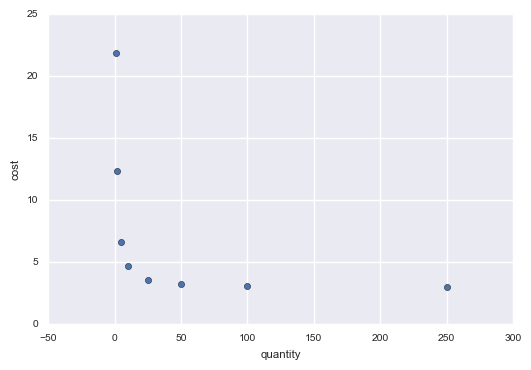

In [294]:
input_tube_assembly = raw_input('Enter Tube Assembly ID: ')

df[df.tube_assembly_id == input_tube_assembly].plot.scatter(x = 'quantity', y = 'cost')

#### Curve fitting 

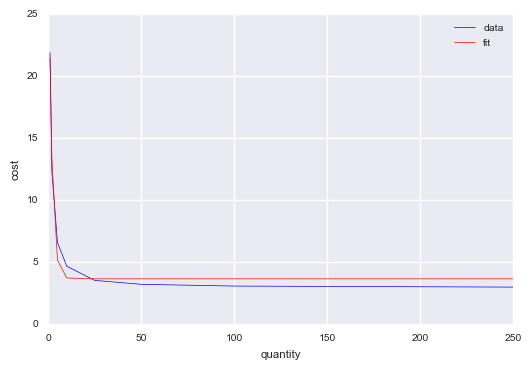

In [385]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = df[df.tube_assembly_id == input_tube_assembly].quantity
ydata = df[df.tube_assembly_id == input_tube_assembly].cost
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.xlabel('quantity')
plt.ylabel('cost')
plt.legend()
plt.show()

In [280]:
df_grouped = df.groupby(by = ['tube_assembly_id','supplier', 'material_id'])
df_grouped

In [281]:
fixed_cost = df.groupby(by = 'tube_assembly_id').max().cost - df.groupby(by = 'tube_assembly_id').min().cost
variable_cost = df.groupby(by = 'tube_assembly_id').min().cost

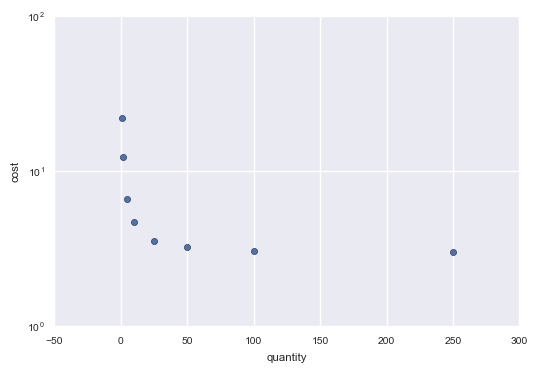

In [282]:
ax = df[df.tube_assembly_id == input_tube_assembly].plot.scatter(x = 'quantity', y = 'cost')
ax.set_yscale('log')

In [395]:
print(df[df.length == 0].length)

376      0.0
377      0.0
378      0.0
379      0.0
380      0.0
381      0.0
382      0.0
383      0.0
384      0.0
1963     0.0
1964     0.0
1965     0.0
1966     0.0
6292     0.0
6293     0.0
6294     0.0
6295     0.0
7173     0.0
7174     0.0
7175     0.0
7176     0.0
7177     0.0
7178     0.0
7179     0.0
7180     0.0
23555    0.0
Name: length, dtype: float64


(array([    58.,   1884.,   5870.,   9869.,  10293.,   2239.]),
 array([   0,    5,   25,   50,  100,  200, 1600]),
 <a list of 6 Patch objects>)

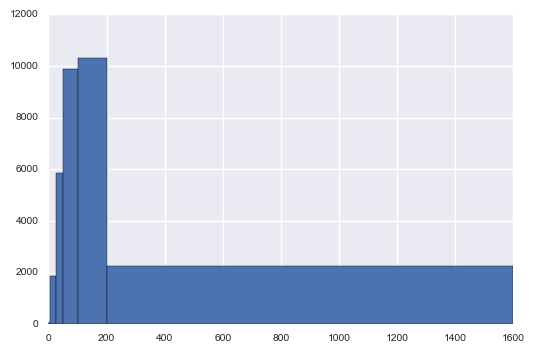

In [396]:
plt.hist(df.length, bins = [0, 5, 25, 50, 100, 200, 1600])

#### Elimination of outliers - length cannot be zero

In [397]:
df_new = df[df.length > 0]
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30187 entries, 0 to 30212
Data columns (total 32 columns):
tube_assembly_id      30187 non-null object
supplier              30187 non-null object
quote_date            30187 non-null datetime64[ns]
annual_usage          30187 non-null int64
min_order_quantity    30187 non-null int64
bracket_pricing       30187 non-null bool
quantity              30187 non-null int64
cost                  30187 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29958 non-null object
diameter              30187 non-null float64
wall                  30187 non-null float64
length              

(array([    32.,   1884.,   5870.,   9869.,  10293.,   2239.]),
 array([   0,    5,   25,   50,  100,  200, 1600]),
 <a list of 6 Patch objects>)

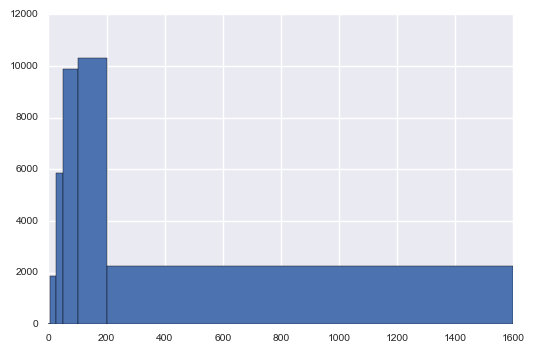

In [398]:
plt.hist(df_new.length, bins = [0, 5, 25, 50, 100, 200, 1600])

(array([     0.,     66.,  13012.,  12020.,   3496.,   1581.]),
 array([   0. ,    2.5,    5. ,   10. ,   25. ,   50. ,  200. ]),
 <a list of 6 Patch objects>)

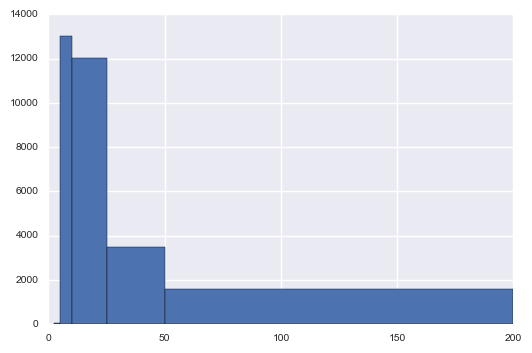

In [399]:
plt.hist(df_new.diameter, bins = [0, 2.5, 5, 10, 25, 50, 200])

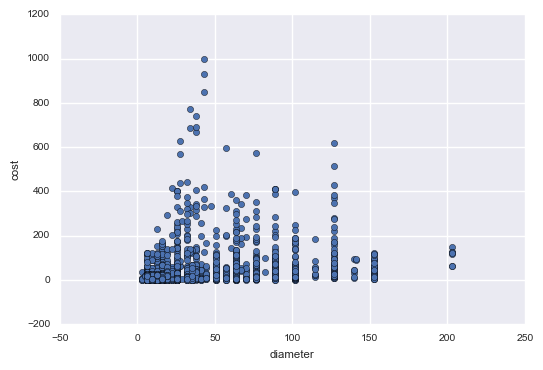

In [400]:
df_new[df_new.quantity == 1].plot.scatter(x = 'diameter', y = 'cost')

#### Log Transformation - Cost has a funnel shape

/Users/GS7271/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


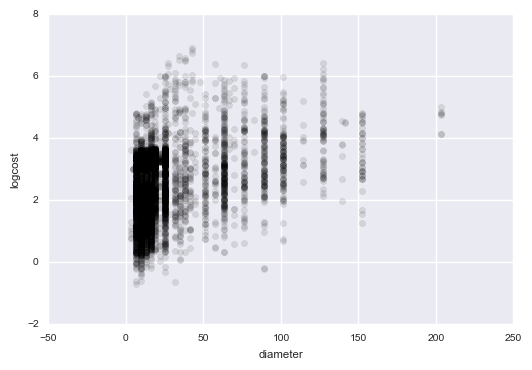

In [418]:
df_new.loc[:,("logcost")] = np.log(df_new["cost"])
df_new[df_new.quantity == 1].plot.scatter(x = 'diameter', y = 'logcost', c='k', alpha = 0.1)

In [419]:
df_new.logcost

0        3.086758
1        2.512944
2        1.887346
3        1.544957
4        1.264568
5        1.170749
6        1.125748
7        1.098299
8        3.089801
9        2.518340
10       1.897409
11       1.559100
12       1.283245
13       1.191245
14       1.147177
15       1.120318
16       3.345481
17       2.804227
18       2.240475
19       1.949828
20       1.723314
21       1.647524
22       1.610978
23       1.588505
24       3.109733
25       2.553370
26       1.962026
27       1.648595
28       1.398884
29       1.318097
           ...   
30183    2.072963
30184    2.770825
30185    2.121470
30186    2.702342
30187    1.527596
30188    1.771773
30189    2.789633
30190    0.959186
30191    3.134858
30192    2.083063
30193    1.923759
30194    1.835454
30195    1.738589
30196    1.708810
30197    1.668198
30198    1.784931
30199    4.249599
30200    4.281480
30201    3.352905
30202    3.078596
30203    2.498412
30204    1.860439
30205    1.506851
30206    1.212985
30207    1

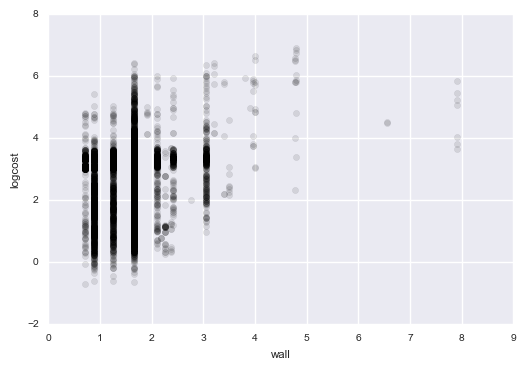

In [402]:
df_new[df_new.quantity == 1].plot.scatter(x = 'wall', y = 'logcost', c='k', alpha = 0.1)

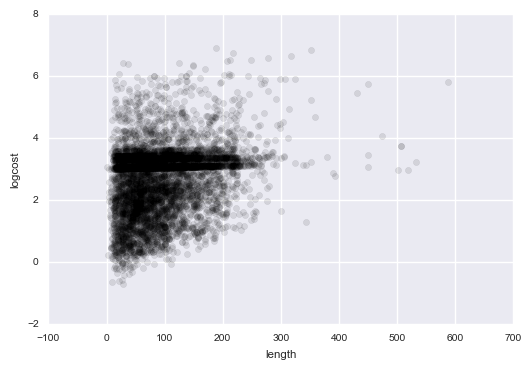

In [403]:
df_new[df_new.quantity == 1].plot.scatter(x = 'length', y = 'logcost', c='k', alpha = 0.1)

(array([  1208.,  10816.,   9516.,   7139.,   1433.,     55.,      0.,
             0.]),
 array([  0,  15,  30,  45,  90, 180, 270, 360, 480]),
 <a list of 8 Patch objects>)

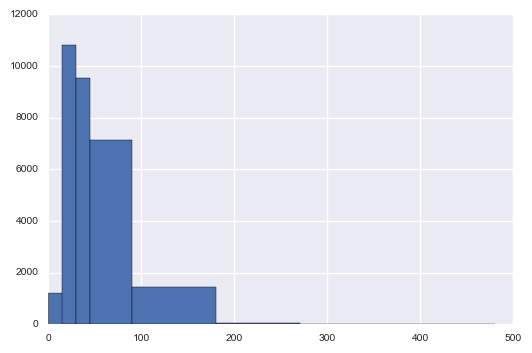

In [404]:
plt.hist(df_new.bend_radius, bins = [0, 15, 30, 45, 90, 180, 270, 360, 480])

#### Elimination of outliers - bend radius cannot be greater than 360 degrees

In [416]:
df_new = df[df.bend_radius <= 360]
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30193 entries, 0 to 30212
Data columns (total 32 columns):
tube_assembly_id      30193 non-null object
supplier              30193 non-null object
quote_date            30193 non-null datetime64[ns]
annual_usage          30193 non-null int64
min_order_quantity    30193 non-null int64
bracket_pricing       30193 non-null bool
quantity              30193 non-null int64
cost                  30193 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29964 non-null object
diameter              30193 non-null float64
wall                  30193 non-null float64
length              

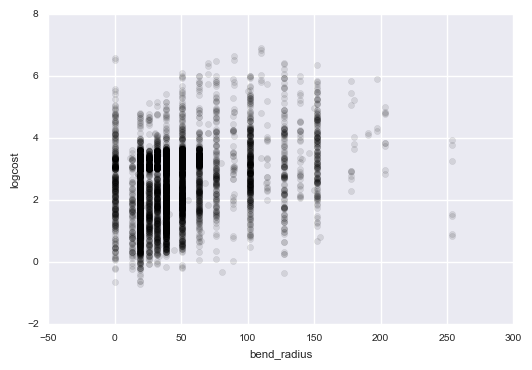

In [426]:
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'bend_radius', y = 'logcost', c='k', alpha = 0.1)

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


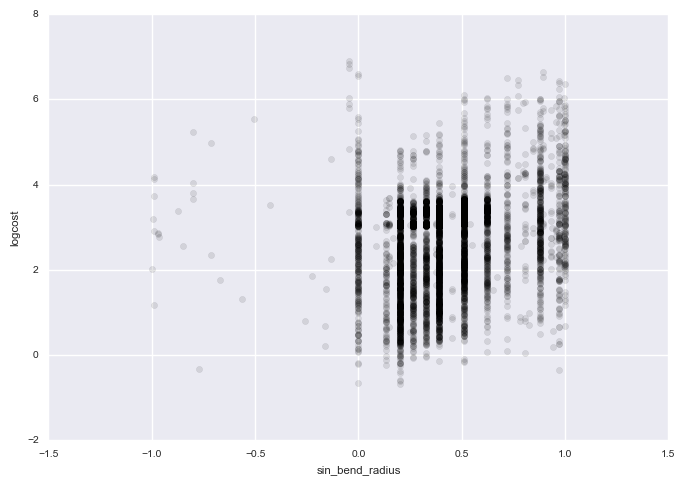

In [440]:
df_new["sin_bend_radius"] = np.sin(df_new["bend_radius"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'sin_bend_radius', y = 'logcost', c='k', alpha = 0.1)

### Creation of a New Variable: Volume = f(wall thickness, diameter, length)

Volume = pi() (wall^2 + diameter x wall) length

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


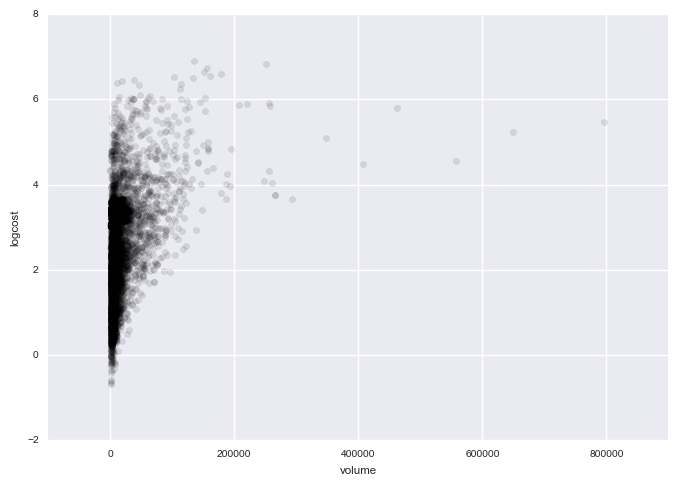

In [455]:
import math
df_new["volume"] = math.pi*(pow((df_new["wall"]), 2) + (df_new["wall"]*df_new["diameter"]))*(df_new["length"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'volume', y = 'logcost', c='k', alpha = 0.1)

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


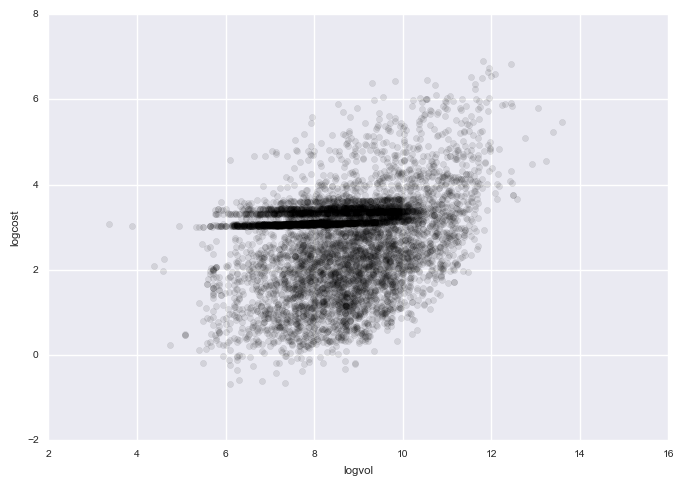

In [456]:
df_new["logvol"] = np.log(df_new["volume"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'logvol', y = 'logcost', c='k', alpha = 0.1)

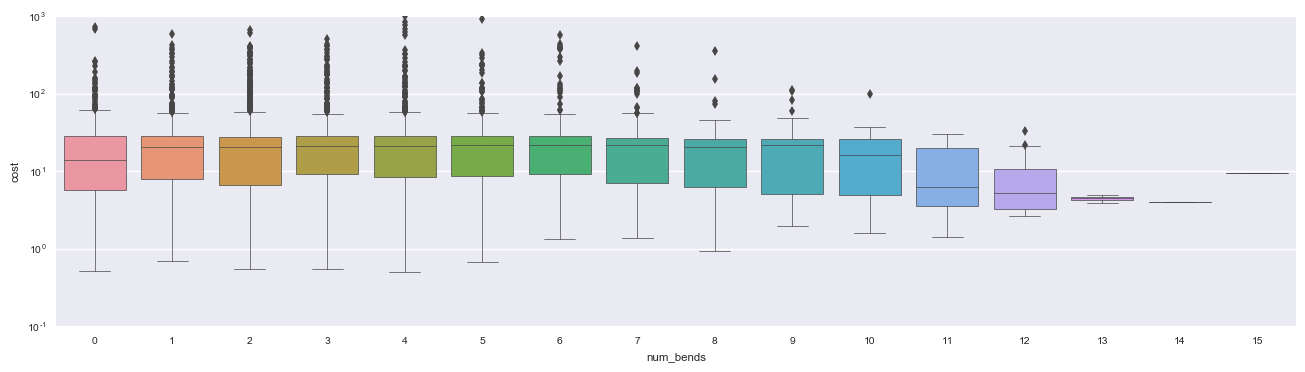

In [356]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_bends", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

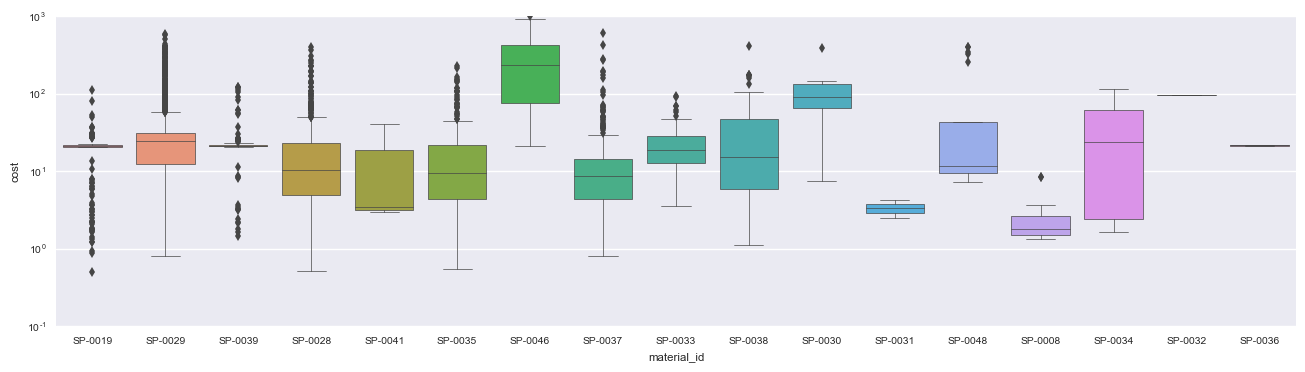

In [357]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "material_id", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

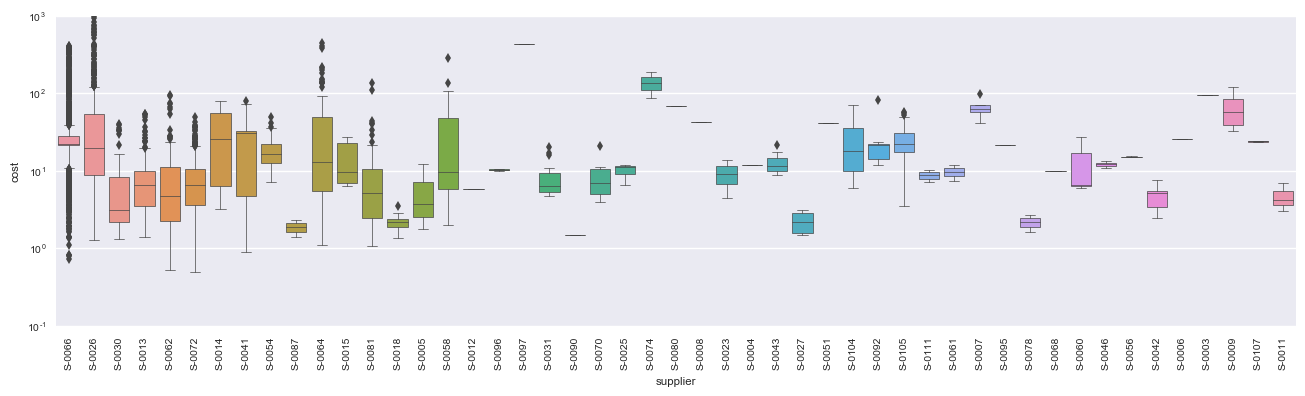

In [358]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "supplier", y = "cost", data = df_new[df_new.quantity == 1])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
sns.despine(left = True)
ax.set_yscale('log')

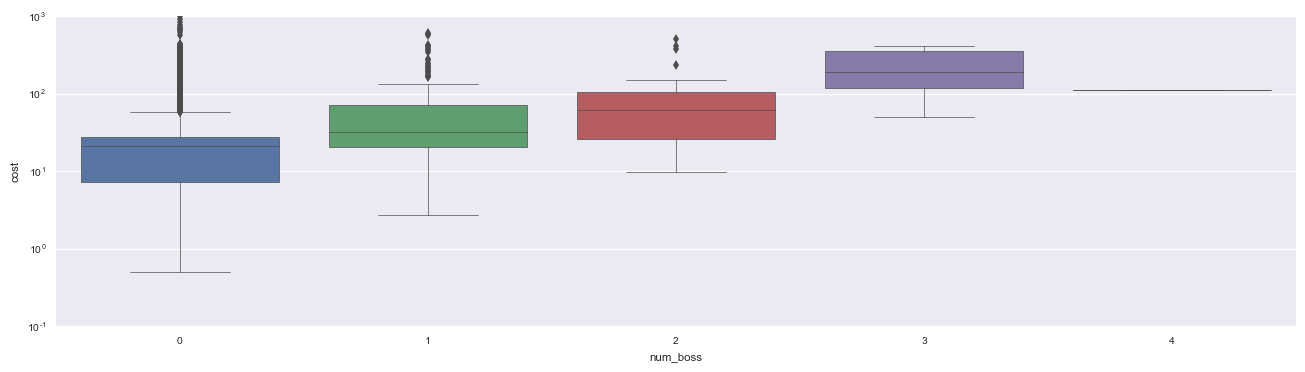

In [430]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_boss", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

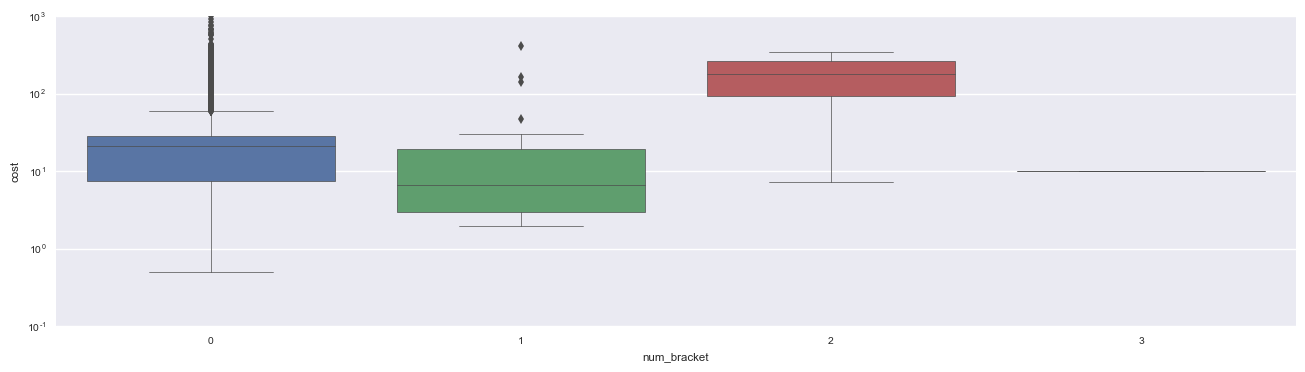

In [431]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_bracket", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

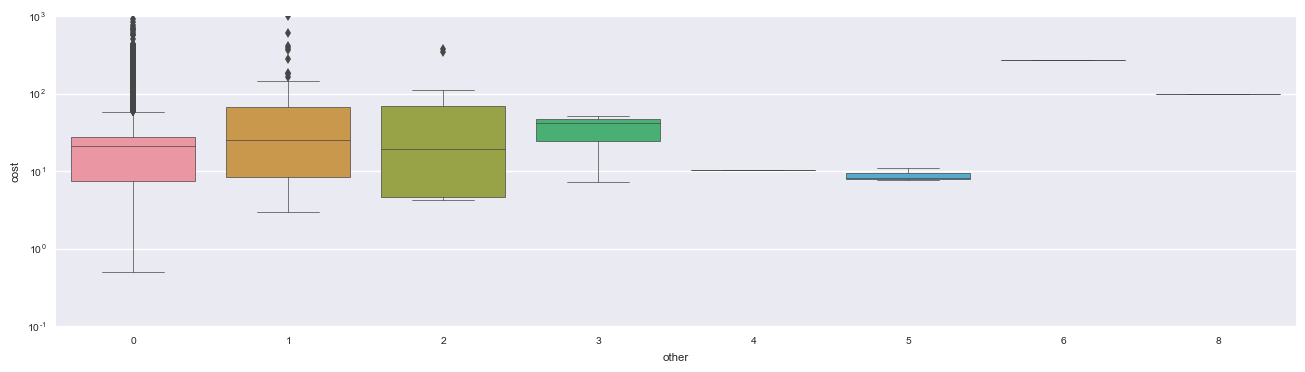

In [432]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "other", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

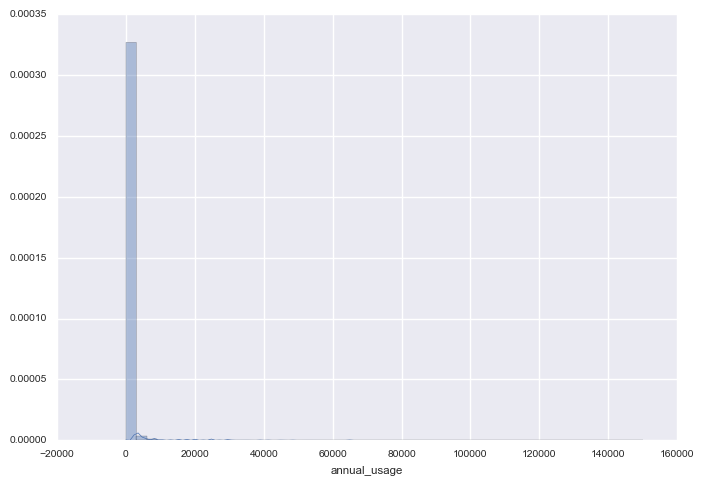

In [359]:
sns.distplot(df_new[df_new.quantity == 1].annual_usage)

### Distribution of Quotes by Year

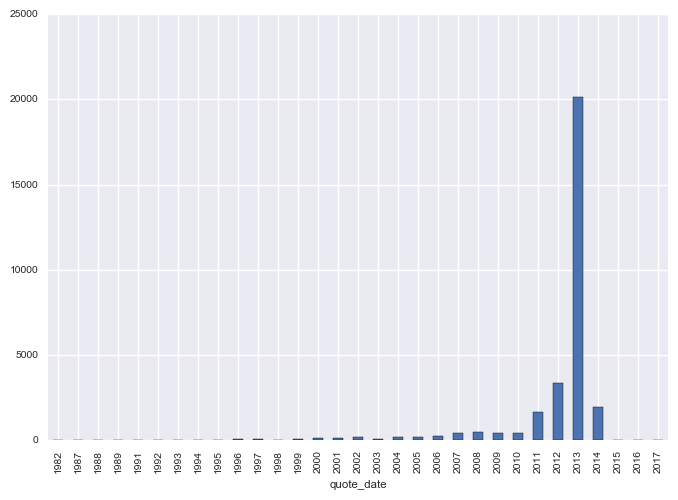

In [289]:
df.groupby(df["quote_date"].dt.year)["quote_date"].count().plot(kind="bar")

In [233]:
print(df.groupby(df["quote_date"].dt.year)["quote_date"].count())

quote_date
1982        6
1987        1
1988        2
1989        2
1991        2
1992        3
1993        4
1994        9
1995       28
1996       47
1997       63
1998       29
1999       79
2000      156
2001      146
2002      187
2003       91
2004      170
2005      180
2006      229
2007      400
2008      478
2009      410
2010      419
2011     1641
2012     3358
2013    20118
2014     1929
2015       22
2016        3
2017        1
Name: quote_date, dtype: int64


### Interactive Chart of Cost = f(Quantity) for specific Materials

Enter Material ID: SP-0031
Enter Supplier ID: S-0066
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 7071 to 7072
Data columns (total 32 columns):
tube_assembly_id      2 non-null object
supplier              2 non-null object
quote_date            2 non-null datetime64[ns]
annual_usage          2 non-null int64
min_order_quantity    2 non-null int64
bracket_pricing       2 non-null bool
quantity              2 non-null int64
cost                  2 non-null float64
spec1                 2 non-null object
spec2                 2 non-null object
spec3                 2 non-null object
spec4                 0 non-null object
spec5                 0 non-null object
spec6                 0 non-null object
spec7                 0 non-null object
spec8                 0 non-null object
spec9                 0 non-null object
material_id           2 non-null object
diameter              2 non-null float64
wall                  2 non-null float64
length                2 non-null f

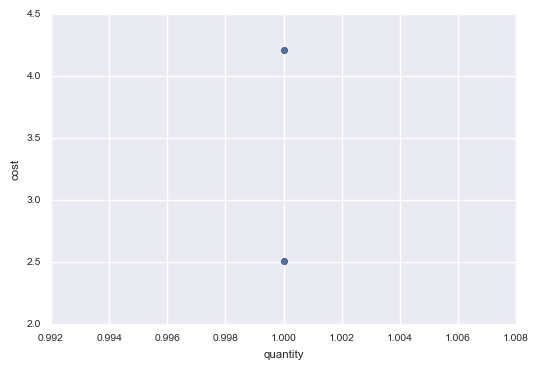

In [387]:
# my original intention was to select Material AND Supplier, but the code below isn't working

input_material = raw_input('Enter Material ID: ')
input_supplier = raw_input('Enter Supplier ID: ')
df_new_selected = df_new[df_new.material_id == input_material]
#df_new_selected = df_new[df_new.supplier == input_supplier]
print(df_new_selected.info())
df_new_selected.plot.scatter(x = 'quantity', y = 'cost')

### Matrix Plot - Continuous Variables 

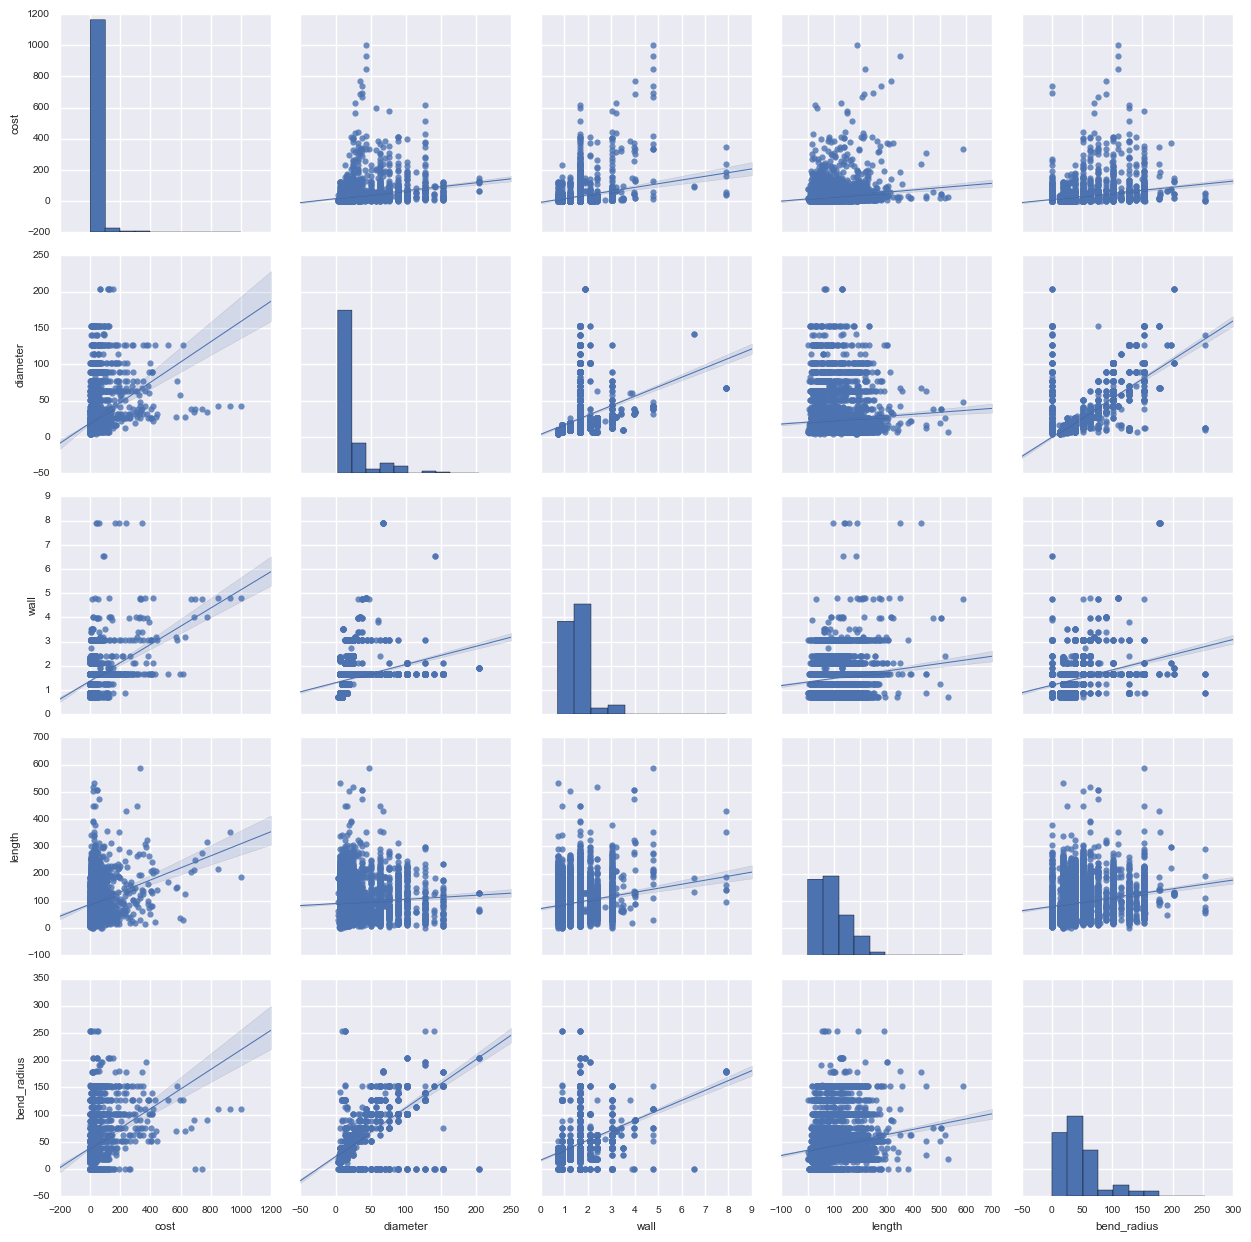

In [388]:
g = sns.pairplot(df_new[df_new.quantity == 1][continuous_features], kind = "reg")

### Matrix Plot - Integer Variables  

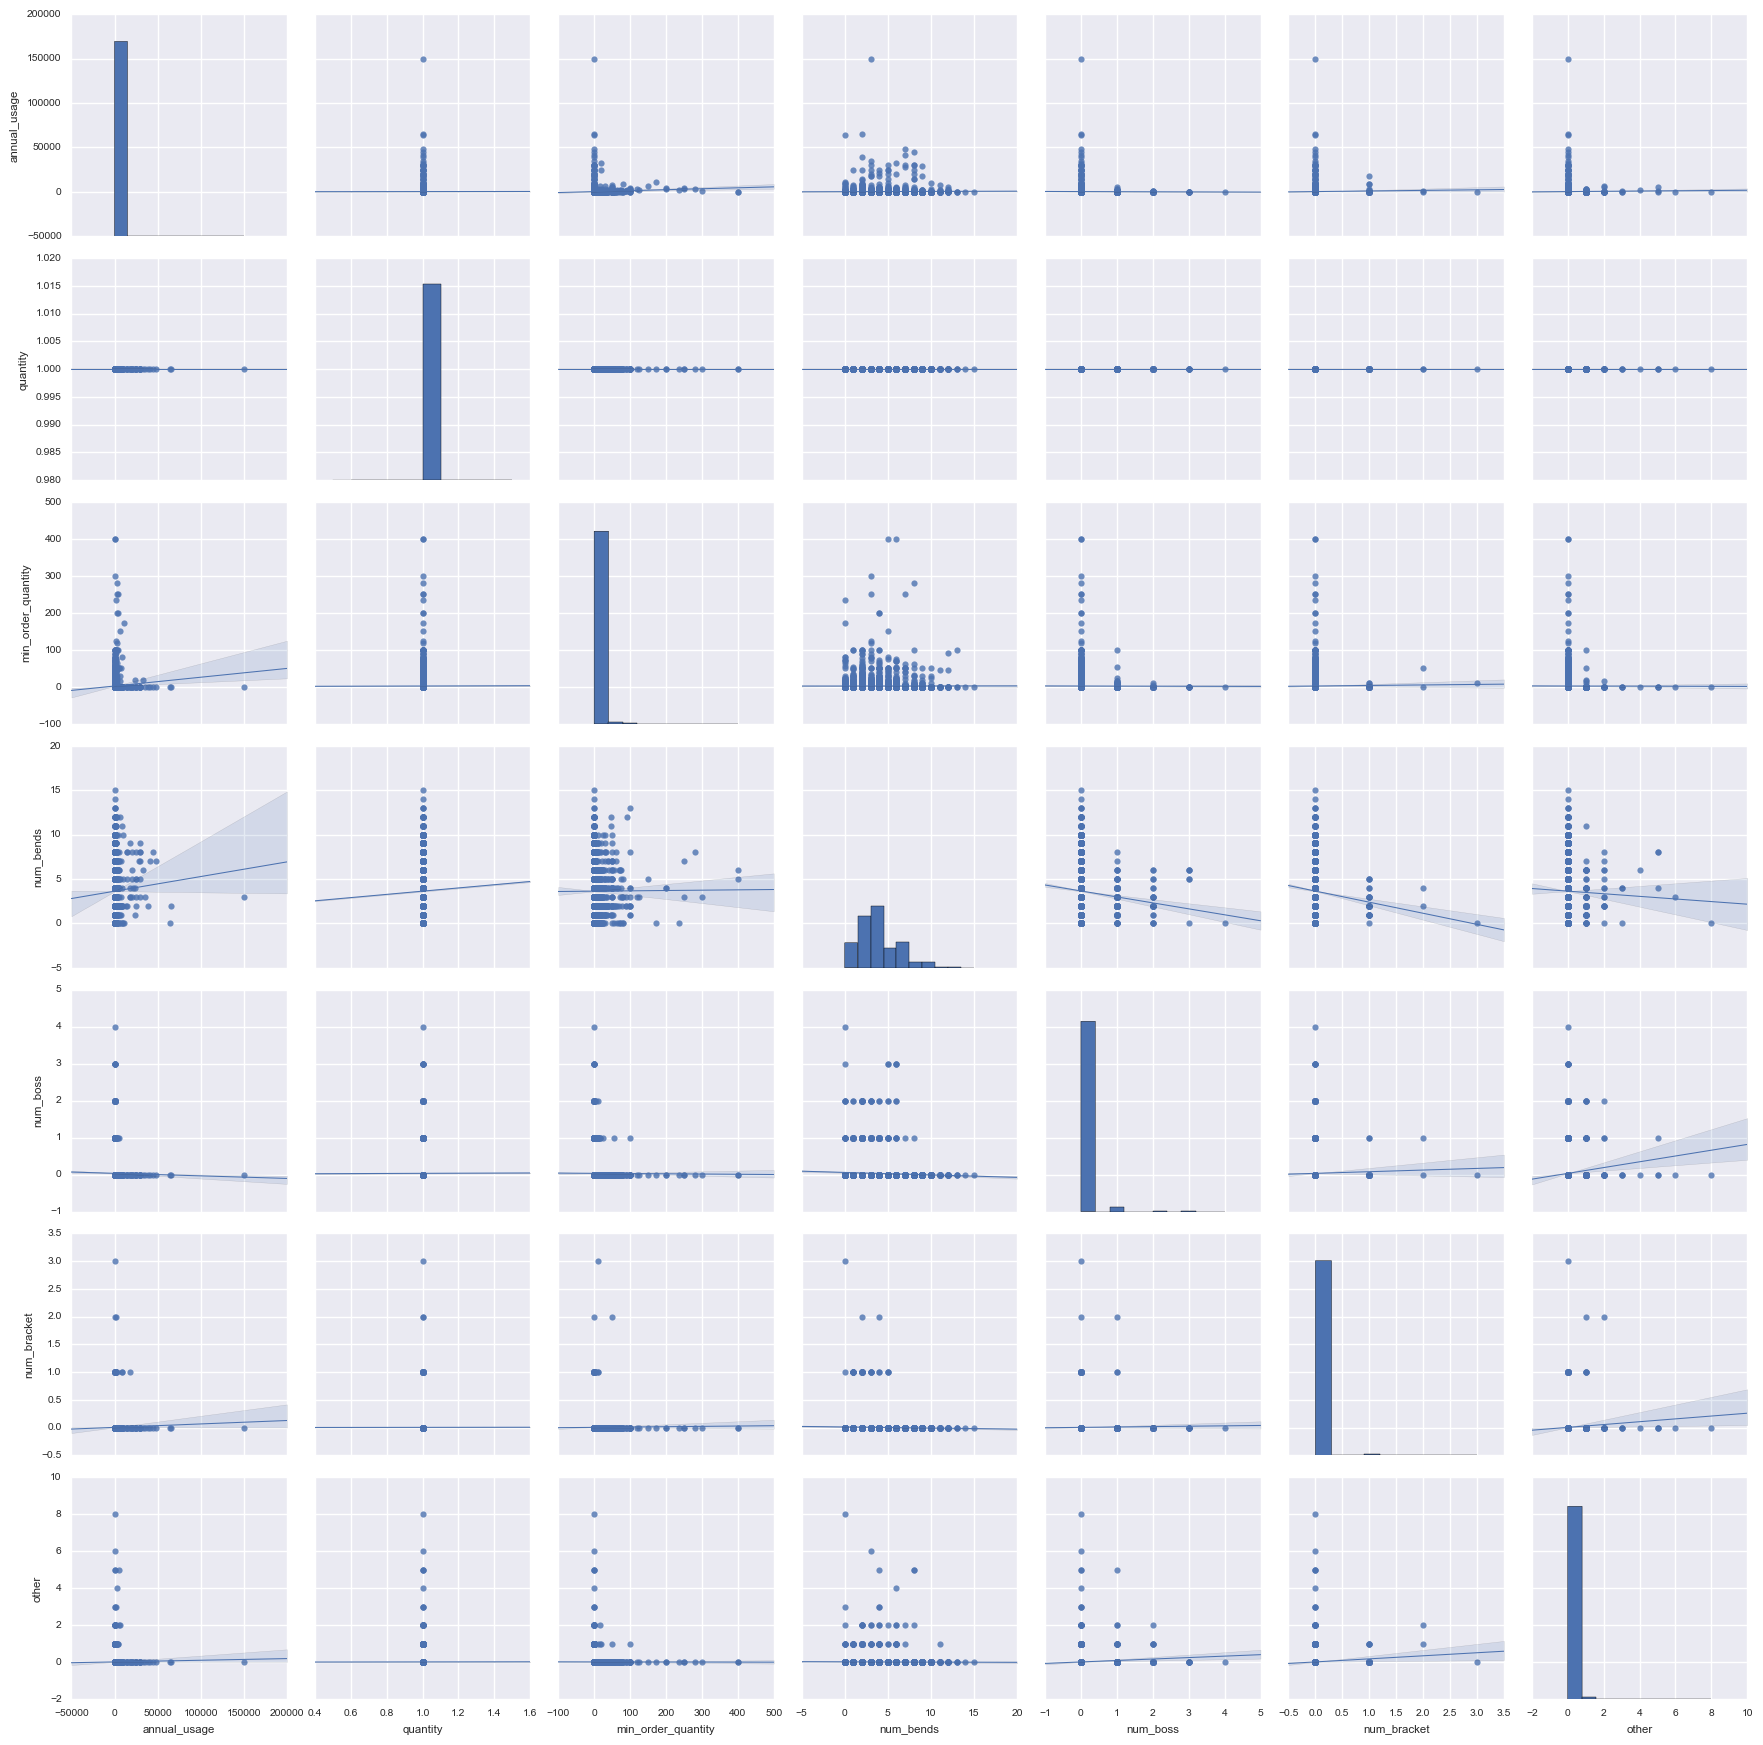

In [372]:
g = sns.pairplot(df_new[df_new.quantity == 1][integer_features], kind = "reg")

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5]), <a list of 22 Text xticklabel objects>)

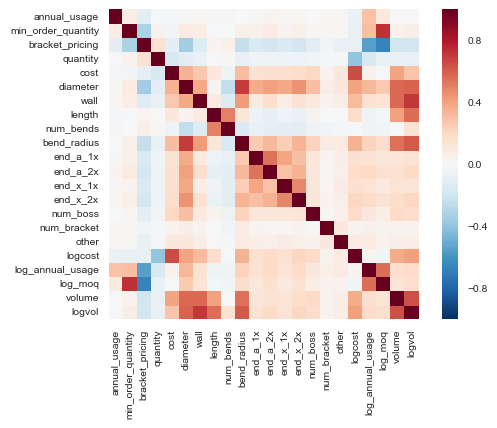

In [429]:
# data set and correlation between the variables after cleaning and formatting it

cm = df_new.corr()
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Please note: my attempt to show multiple plots (below) is not working

KeyError: 'logcost'

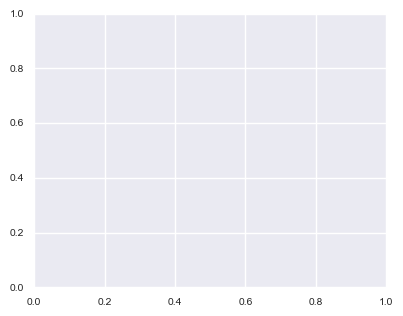

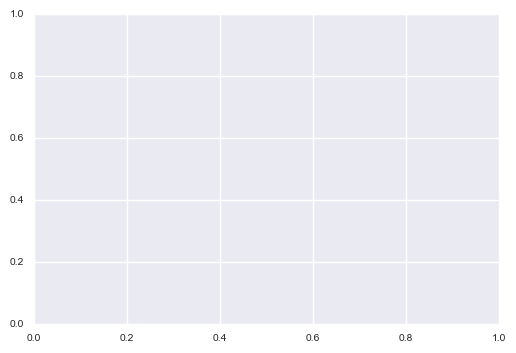

In [389]:
plt.figure(figsize = (10, 12))

integer_features = ['annual_usage', 'min_order_quantity', 'num_bends', 'num_boss', 'num_bracket', 'other']

for index, plot_vars in enumerate (integer_features):
    plt.subplot(len(integer_features)/2,
               2,
               index + 1)
    ax = df_new[df_new.quantity == 1].plot.scatter(x = plot_vars, y = 'logcost', c='k', alpha = 0.1)
    
plt.show()

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


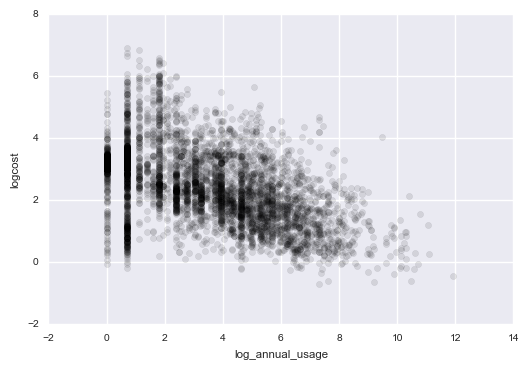

In [420]:
df_new["log_annual_usage"] = np.log(df_new["annual_usage"] + 1)
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'log_annual_usage', y = 'logcost', c='k', alpha = 0.1)

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


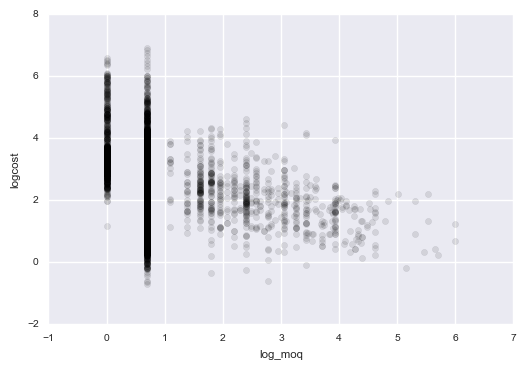

In [425]:
df_new["log_moq"] = np.log(df_new["min_order_quantity"] + 1)
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'log_moq', y = 'logcost', c='k', alpha = 0.1)

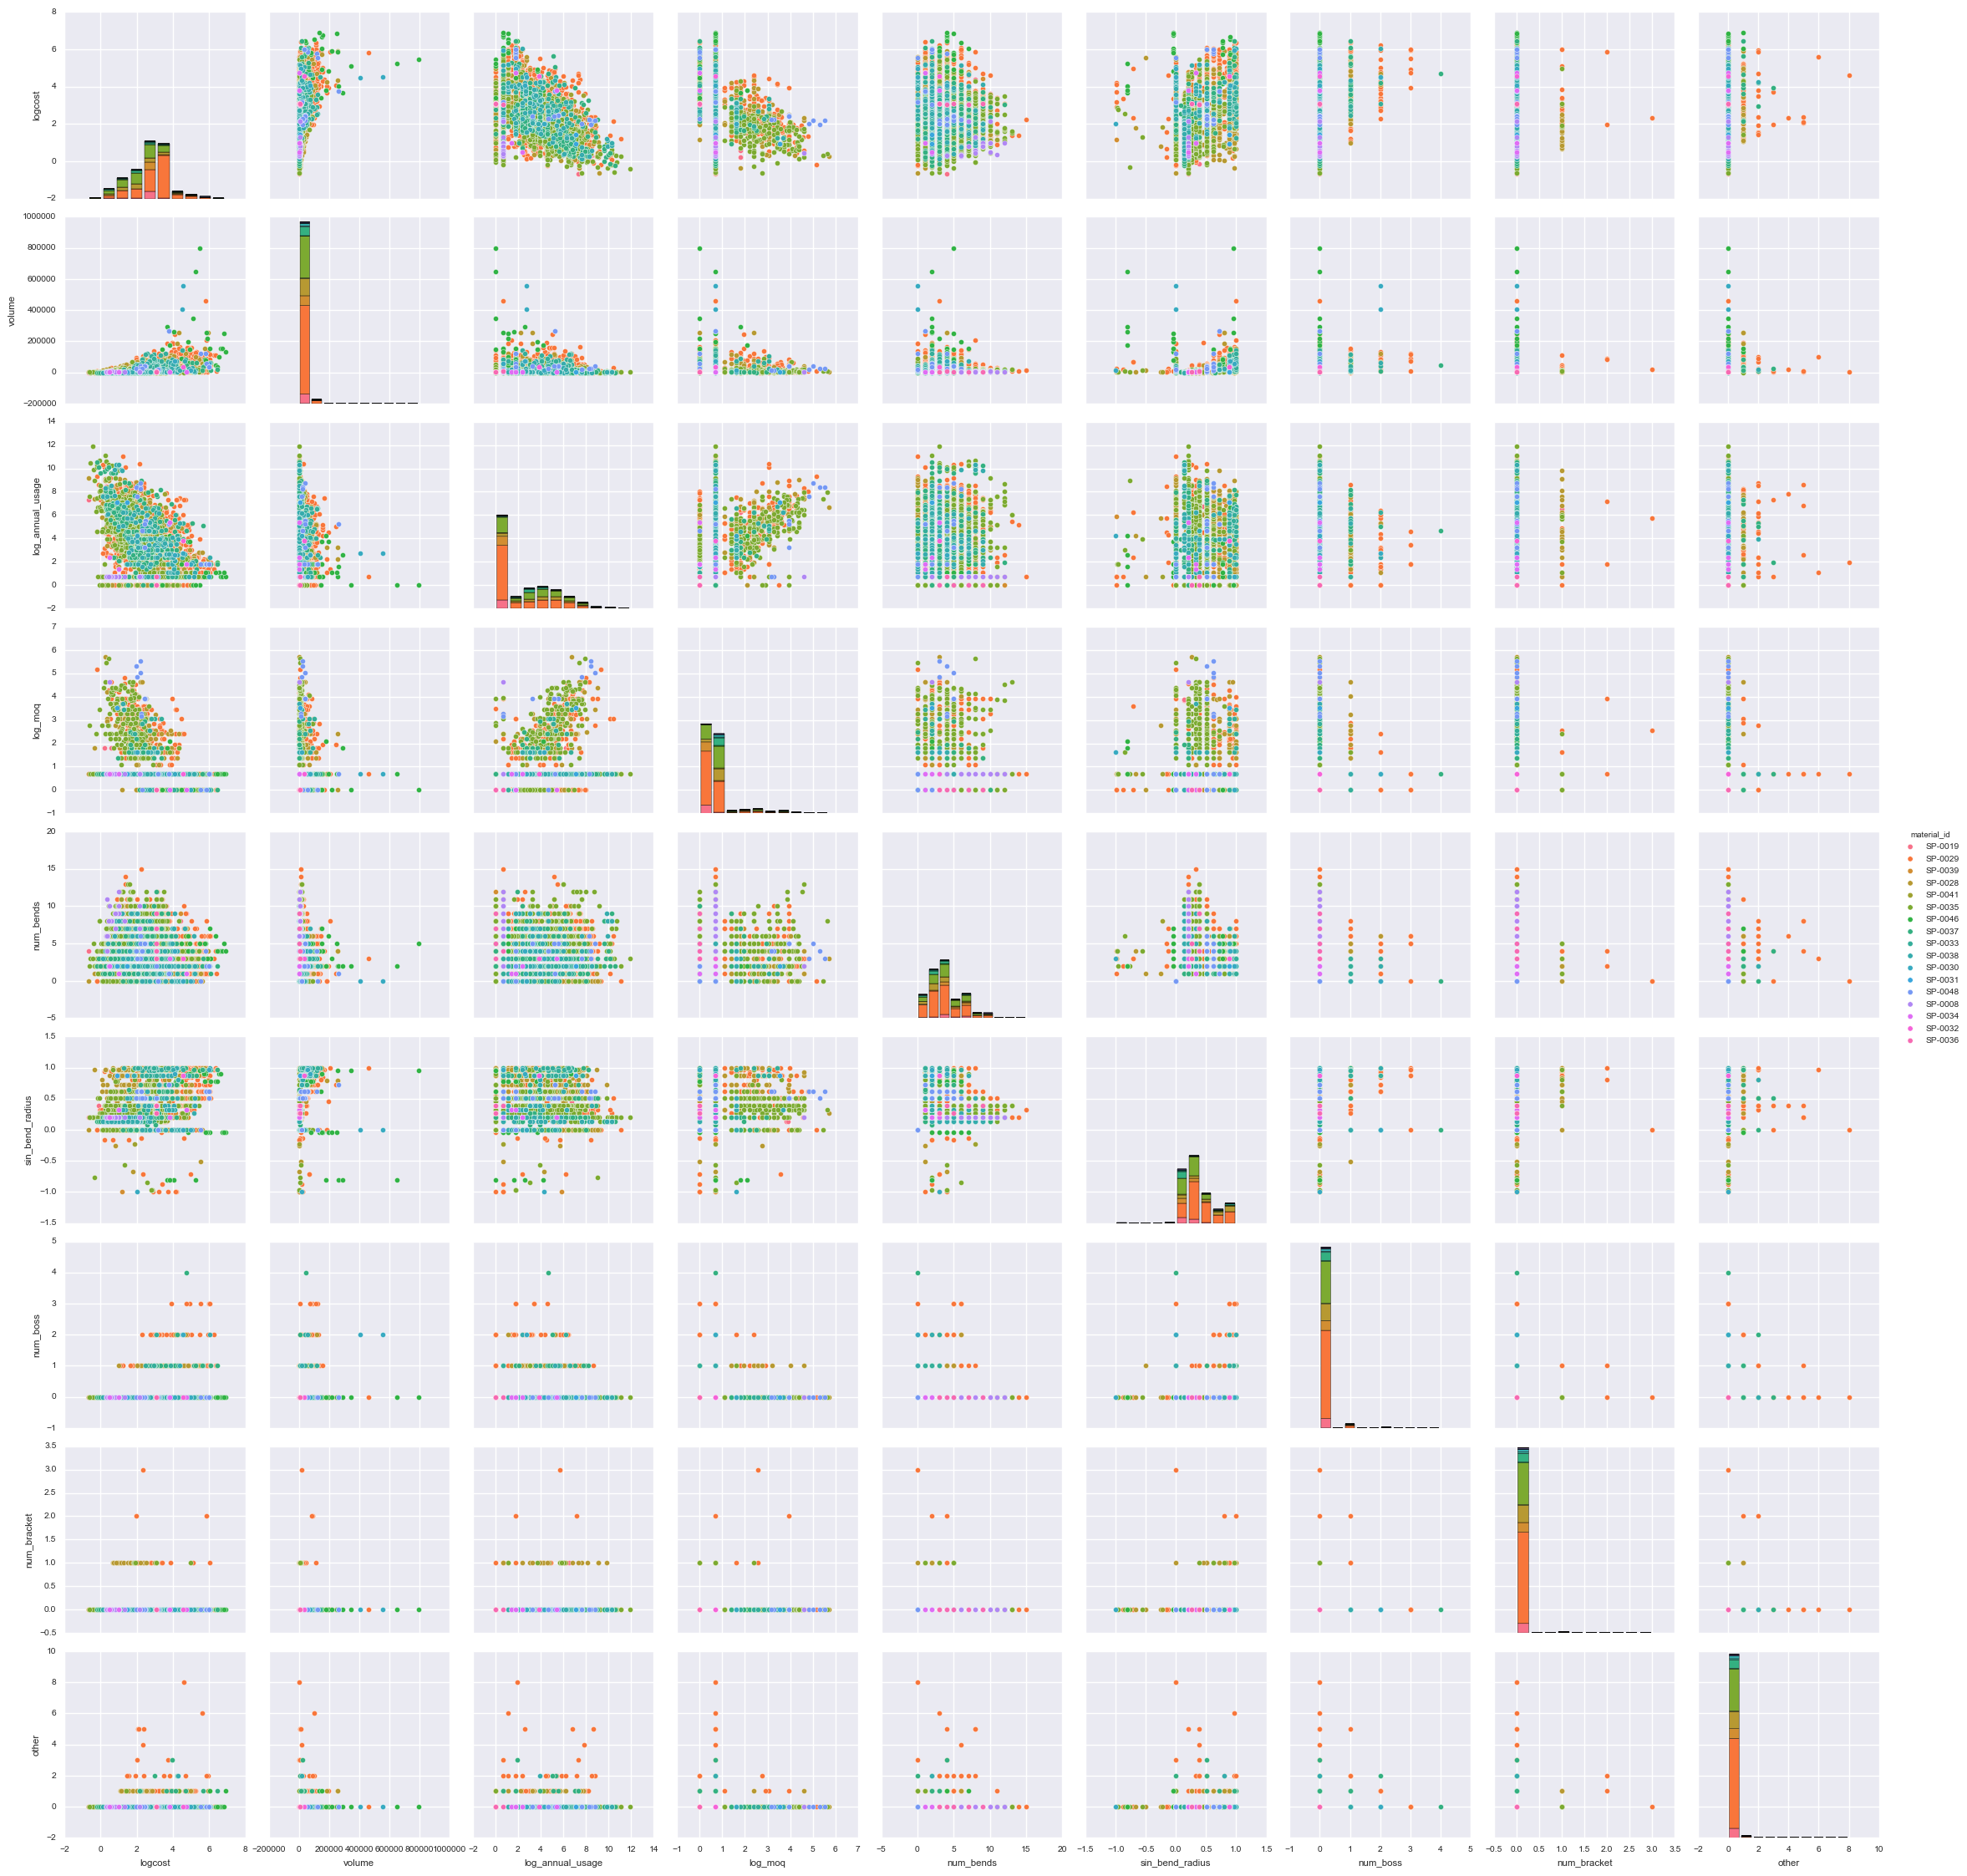

In [474]:
transformed_features = ['logcost', 'volume', 'log_annual_usage', 'log_moq', 'num_bends', 'sin_bend_radius', 'num_boss', 'num_bracket', 'other', 'material_id']
g = sns.pairplot(df_new[df_new.quantity == 1][transformed_features], hue = 'material_id')

In [450]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30193 entries, 0 to 30212
Data columns (total 38 columns):
tube_assembly_id      30193 non-null object
supplier              30193 non-null object
quote_date            30193 non-null datetime64[ns]
annual_usage          30193 non-null int64
min_order_quantity    30193 non-null int64
bracket_pricing       30193 non-null bool
quantity              30193 non-null int64
cost                  30193 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29964 non-null object
diameter              30193 non-null float64
wall                  30193 non-null float64
length              

In [475]:
selected_features = ['logcost', 'volume','log_annual_usage', 'log_moq', 'num_bends', 'sin_bend_radius', 'num_boss', 'num_bracket', 'other']
df_selected = df_new[selected_features]
df_selected.describe()

,logcost,volume,log_annual_usage,log_moq,num_bends,sin_bend_radius,num_boss,num_bracket,other
count,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000,30193.000000
mean,2.037992,10009.665959,1.121160,0.272824,3.814096,0.365885,0.025271,0.003544,0.013612
std,0.923825,20577.637883,1.918193,0.786185,2.199851,0.204223,0.185036,0.069687,0.150890
min,-0.686067,0.000000,0.000000,0.000000,0.000000,-0.999755,0.000000,0.000000,0.000000
25%,1.355369,1905.453228,0.000000,0.000000,2.000000,0.199105,0.000000,0.000000,0.000000
50%,1.875050,4110.143155,0.000000,0.000000,3.000000,0.327894,0.000000,0.000000,0.000000
75%,2.596587,10982.093085,1.098612,0.000000,5.000000,0.509426,0.000000,0.000000,0.000000
max,6.907755,796130.472221,11.918397,6.284134,17.000000,0.999464,5.000000,3.000000,8.000000


In [491]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(df_selected)

PCA(copy=True, n_components=2, whiten=False)

In [490]:
pca.components_

array([[ -1.68245352e-05,  -1.00000000e+00,  -1.55226173e-05,
         -5.28284573e-06,   1.48364328e-06,  -4.04288062e-06,
         -1.80731174e-06,  -1.26600857e-07,  -4.79987754e-07],
       [  1.76730231e-03,  -4.41710854e-06,   1.69539479e-01,
          4.47140360e-02,  -9.84417266e-01,   1.19940199e-02,
          5.09434270e-03,   1.32201531e-03,   2.23301927e-03]])

In [492]:
X = df_selected.ix[:, df_selected.columns != 'logcost']
Y = df_selected.logcost
#target_names = iris.target_names

pca = PCA(n_components = 2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

print ('pca:', pca.components_)

('pca:', array([[  1.00000000e+00,   1.55226173e-05,   5.28284573e-06,
         -1.48364328e-06,   4.04288062e-06,   1.80731174e-06,
          1.26600856e-07,   4.79987753e-07],
       [  4.38911003e-06,  -1.69641576e-01,  -4.47570394e-02,
          9.84399461e-01,  -1.19850646e-02,  -5.08747591e-03,
         -1.32157823e-03,  -2.23013839e-03]]))


In [493]:
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
pca_weight_strings = get_feature_names_from_weights(pca.components_, df_selected) 

df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])

from pandas.tools.plotting import scatter_plot

ax = scatter_plot(df_selected_pca, pca_weight_strings[0], pca_weight_strings[1], c=y, s=(y+2)*10)
newfig = plt.figure()

IndexError: index 8 is out of bounds for axis 0 with size 8